In [717]:
import numpy as np
import matplotlib.pyplot as plt

from importlib import reload
from tblib import lattice
from tblib import hamiltonian

reload(lattice)
reload(hamiltonian)

<module 'tblib.hamiltonian' from 'c:\\Users\\atsch\\Desktop\\MasterVorlesungen\\Masterthesis\\Code\\tblib\\hamiltonian.py'>

In [718]:
k=np.linspace(0,np.pi, 100)

In [719]:
N=2

lat = lattice.dDiagonallyStripedLattice(N=N)
ham = hamiltonian.Model(N=N, kind='dDSL', delta=[0.5,0.5], U=[1,1])
 

#lat.plot_lattice();

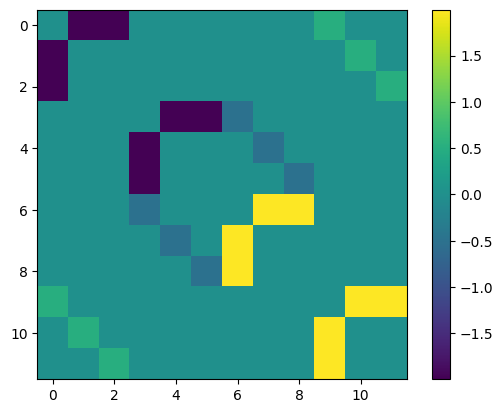

In [720]:
plt.imshow(np.real(ham.Hk(k[2], k[2])[0]))
plt.colorbar()

In [721]:
ham.DeltaN(40, False)

([(0.14461898774595514+2.426657816104683e-18j),
  (0.32230949387297786+6.413429603539735e-18j)],
 [0.0, 0.0])

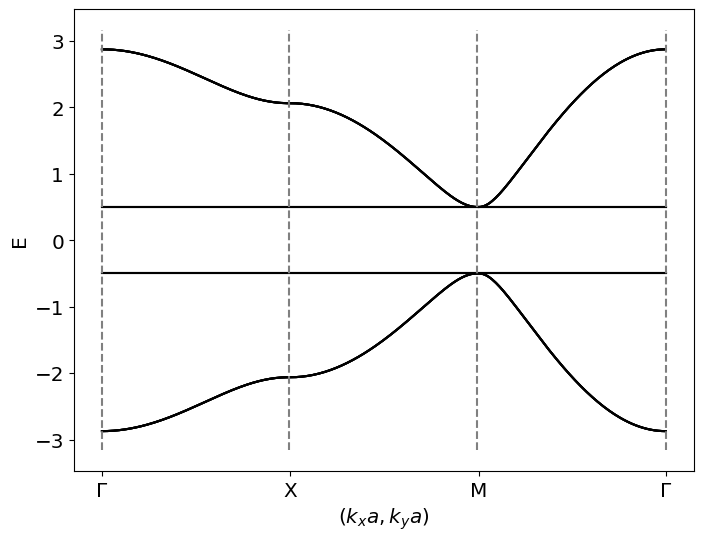

In [722]:
ham.plot_bands(k)

In [723]:
dels, nus = ham.Deltra(40,HF=False, alpha=0.7, Nmin=20)

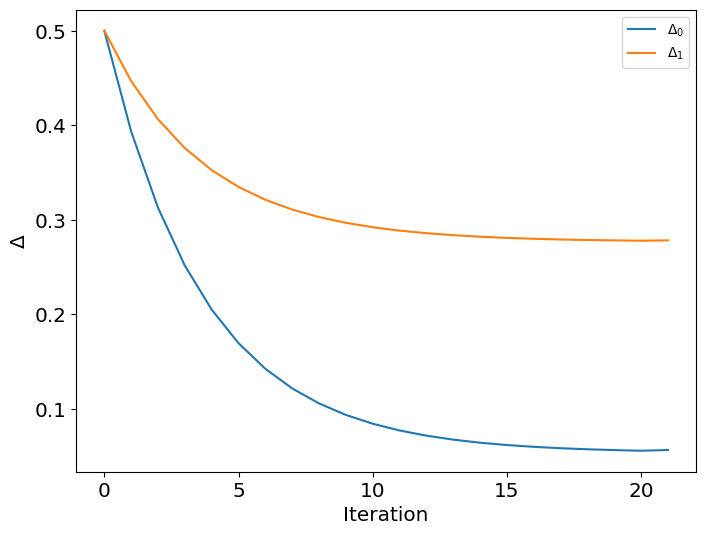

In [724]:
plt.figure(figsize=(8,6))
plt.xlabel('Iteration', size='x-large')
plt.ylabel(r'$\Delta$', size='x-large')
plt.xticks(size='x-large')
plt.yticks(size='x-large')
#plt.ylim(0,0.35)

#plt.plot(np.arange(len(dels[0])), dels[0], label = r'$\Delta_A$')
#plt.plot(np.arange(len(dels[0])), dels[1], label = r'$\Delta_B$')
#plt.plot(np.arange(len(dels[0])), dels[2], label = r'$\Delta_C$')
for i,d in enumerate(dels):
    plt.plot(np.arange(len(dels[0])), np.real(d), label = f'$\Delta_{i}$')

plt.legend()

plt.show()

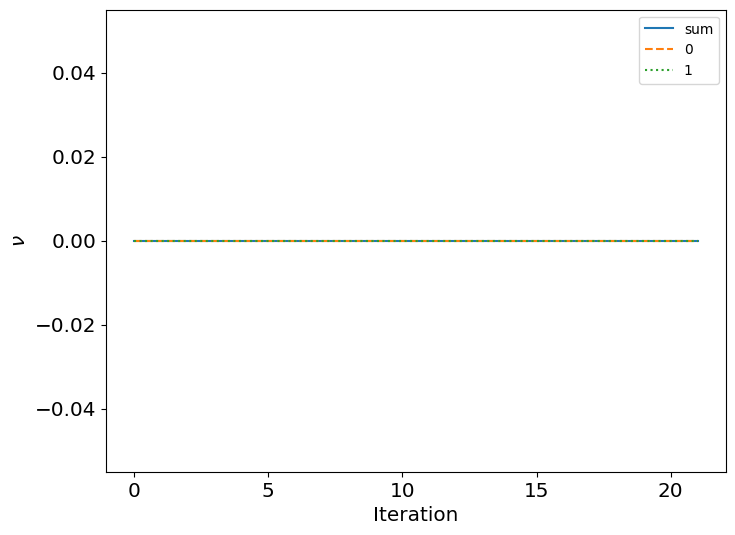

In [725]:
s1 = [np.sum(nus[:,i]) for i in range(np.shape(nus)[1])]

plt.figure(figsize=(8,6))
plt.xlabel('Iteration', size='x-large')
plt.ylabel(r'$\nu$', size='x-large')
plt.xticks(size='x-large')
plt.yticks(size='x-large')
#plt.ylim(0,0.35)
colors=['dashed', 'dotted', 'dashdot']
plt.plot(np.arange(len(s1)), s1, label = r'sum')
for i in range(2):
    plt.plot(np.arange(len(s1)),nus[i],linestyle=colors[i], label=f'{i}')

plt.legend()
plt.show()

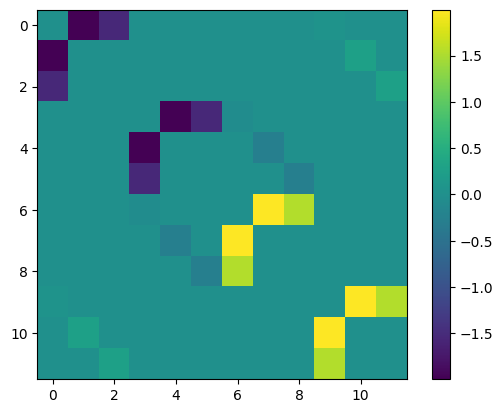

In [726]:
plt.imshow(np.real(ham.Hk(k[20], k[2])[0]))
plt.colorbar()

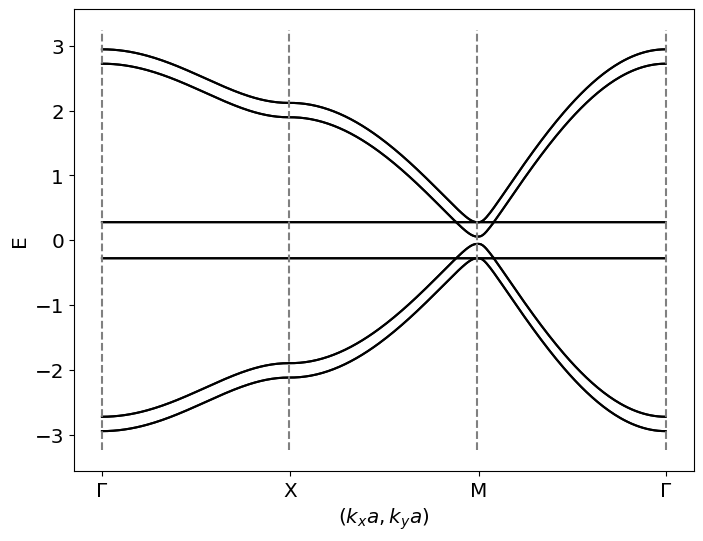

In [727]:
ham.plot_bands(k)

In [728]:
ham.delta

array([0.05662274+1.31798175e-18j, 0.27831137+1.17683687e-18j])

Earr = np.linspace(-2.5,2.5,350)
DOS = np.zeros(350)
for i in range(1):
    DOS+=ham.DOS(Earr,k, b=i,p='all')

plt.xlabel("E", size='x-large')
plt.ylabel("DOS", size='x-large')
plt.yticks(size='x-large')
plt.xticks(size='x-large')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))
plt.xlim(-0.6, 0.6)
#plt.ylim(0, 1e5)
plt.plot(Earr, DOS)
#plt.vlines([emax, -emax], 0, 100, colors='black')

plt.show()

In [729]:
np.linspace(-np.pi, np.pi*0.1, 5)

array([-3.14159265, -2.27765467, -1.41371669, -0.54977871,  0.31415927])

In [730]:
sfw1 = ham.SFW(20, my='x', ny='y')
sfw1

(0.10275671402503456+1.1586723254363977e-18j)

In [736]:
ham.detSFW(50)

(0.3409949849254051-9.758698123438112e-20j)

In [732]:
sfw1/20**2

(0.0002568917850625864+2.896680813590994e-21j)

In [733]:
def fermidirac(E,T=0,o=0):

    nE=0
    if o==0:
        if np.abs(E)<1e-14 and T!=0:
            nE = 1
        elif T==0:
            if E>0:
                nE = 0
            else:
                nE = 1
        else:
            nE = 1/(1+np.exp(E/T))
    elif o==1:
        if np.abs(E)<1e-14 and T!=0:
            nE = 1/(4*T)
        elif T==0:
            nE = 0
        else:
            nE = 1/((1+np.exp(E/T))**2)*np.exp(E)/T

    return nE


def SFW(kx, ky, T=0, my='x', ny='y'):

    gammaz = np.kron(np.diag([1,-1]), np.eye(6))
    sum = 0
    karr = np.linspace(-np.pi,np.pi*0.1,N)
    
    pflist = []
    slist = []

    evals, evec = np.linalg.eigh(ham.Hk(kx,ky)[0])
    Evec = evec.T 

    nE = [fermidirac(E,T,o=0) for E in evals]
    dnE = [fermidirac(E,T,o=1) for E in evals]
    for k,i in enumerate(evals):
        for l,j in enumerate(evals):
            if np.abs(i-j)<1e-10 or k==l:
                pf = -dnE[l]
            else:
                pf = (nE[l]-nE[k])/(i-j)

            f1 = np.matmul(np.conjugate(Evec[k]),np.matmul(ham.Hk(kx,ky,o=my)[0],Evec[l]))
            f2 = np.matmul(np.conjugate(Evec[l]),np.matmul(ham.Hk(kx,ky,o=ny)[0],Evec[k]))

            M1 = np.matmul(ham.Hk(kx,ky,o=my)[0],gammaz)
            M2 = np.matmul(gammaz,ham.Hk(kx,ky,o=ny)[0])

            f3 = np.matmul(np.conjugate(Evec[l]),np.matmul(M1,Evec[k]))
            f4 = np.matmul(np.conjugate(Evec[k]),np.matmul(M2,Evec[l]))

            slist.append((pf*(f1*f2-f3*f4),i,j, f1,f2))
            sum+=pf*(f1*f2-f3*f4)

    return sum, pflist, slist

In [734]:
for kx in karr:
            for ky in karr:

SyntaxError: incomplete input (1287918356.py, line 2)

In [ ]:
sfw = SFW(-np.pi,0.2)

In [ ]:
sfw[0]

In [ ]:
sfw[-1]

In [ ]:
sfw[2]

In [ ]:
sfw[-1]

In [ ]:
0.076265*0.1188

In [ ]:
0.068012*0.105988

In [ ]:
sfw[3][0]*sfw[3][1]-sfw[3][2]*sfw[3][3]